# Librerías

In [21]:
import os 
import h5py
import pickle
import numpy as np
import scanpy as sc 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import scipy.sparse as sp
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import SubplotSpec
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr


In [22]:
from clustering import *

In [23]:
import warnings
warnings.filterwarnings('ignore')

# Utiles

In [24]:
def log_1(x):
    return np.log10(x+1)

In [25]:
def get_distances_matrix(X, tipo = 'similitud'):
    num_cells = X.shape[0]
    num_genes = X.shape[1]
    distancias = np.zeros((num_cells, num_cells))

    for c1 in tqdm(range(num_cells)):
        celula1 = X[c1,:]
        indices_nocero1 = celula1.nonzero()[1]
        for c2 in range(c1, num_cells):
            celula2 = X[c2,:]
            indices_nocero2 = celula2.nonzero()[1]

            if tipo == 'similitud':
                indices_comunes = set(indices_nocero1).intersection(set(indices_nocero2))
                distancias[c1][c2] = len(indices_comunes)
                distancias[c2][c1] = len(indices_comunes)

            elif tipo == 'euclidea':
                dist = euclidean(np.array(celula1.todense())[0,:], np.array(celula2.todense())[0,:])
                distancias[c1][c2] = dist
                distancias[c2][c1] = dist

            elif tipo == 'correlacion_pearson':
                indices_comunes = list(set(indices_nocero1).intersection(set(indices_nocero2)))
                x1 = np.array(celula1.todense())[0,indices_comunes]
                x2 = np.array(celula2.todense())[0,indices_comunes]
                corr = pearsonr(x1, x2)
                distancias[c1][c2] = corr.statistic
                distancias[c2][c1] = corr.statistic

            elif tipo == 'rango_spearman':
                indices_comunes = list(set(indices_nocero1).intersection(set(indices_nocero2)))
                x1 = np.array(celula1.todense())[0,indices_comunes]
                x2 = np.array(celula2.todense())[0,indices_comunes]
                corr = spearmanr(x1, x2)
                distancias[c1][c2] = corr.correlation 
                distancias[c2][c1] = corr.correlation 
            
    return distancias

In [26]:
def distancias_mismo_diferente_cluster(distancias_dict, adata_dict):    
    distancias_mismo_cluster_dict = {}
    distancias_diferente_cluster_dict = {}

    for key in distancias_dict.keys():
        distancias = distancias_dict[key]
        adata = adata_dict[key]

        num_celulas = adata.X.shape[0]

        # Ahora miramos cómo cambia esta distribución en pares de células del mismo cluster 
        distancia_mismo_cluster = []
        distancia_diferente_cluster = []

        for c1 in tqdm(range(num_celulas)):
            g1 = adata.obs.iloc[c1].Group
            for c2 in range(c1+1, num_celulas):
                g2 = adata.obs.iloc[c2].Group

                if g1 == g2: distancia_mismo_cluster.append(distancias[c1][c2])
                else: distancia_diferente_cluster.append(distancias[c1][c2])

        distancias_mismo_cluster_dict[key] = distancia_mismo_cluster
        distancias_diferente_cluster_dict[key] = distancia_diferente_cluster
    
    return distancias_mismo_cluster_dict, distancias_diferente_cluster_dict

In [27]:
def create_subtitle(fig: plt.Figure, grid, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [28]:
def normalize(adata, filter_min_counts=True, size_factors=True, normalize_input=True, logtrans_input=True):
    if filter_min_counts:
        sc.pp.filter_genes(adata, min_counts=1)
        sc.pp.filter_cells(adata, min_counts=1)

    if size_factors or normalize_input or logtrans_input:
        adata.raw = adata.copy()
    else:
        adata.raw = adata

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)

    return adata

# Lectura de datos 

In [29]:
path = '../Tests-GMM/data/Small_Datasets/'

In [30]:
data10x = h5py.File(path + '10X_PBMC_select_2100_top2000.h5')
dataHumanLiver = h5py.File(path + 'HumanLiver_counts_top5000.h5')
dataMacosko = h5py.File(path + 'Macosko_mouse_retina.h5')
dataWorm = h5py.File(path + 'worm_neuron_cell.h5')
dataBladder = h5py.File(path + 'mouse_bladder_cell.h5')

data = {'10X_PBMC': data10x, 'HumanLiver': dataHumanLiver, 'Macosko': dataMacosko, 
        'WormNeuron': dataWorm, 'MouseBladder': dataBladder}

In [31]:
adata_dict = {}
for key, item in data.items():
    x = np.array(item['X'])
    y = np.array(item['Y'])

    adata = sc.AnnData(x)
    adata.obs['Group'] = y

    adata_dict[key] = adata

# Análisis 

Visualizamos las distribuciones de los count per cell y count per gene con transformación logarítmica.

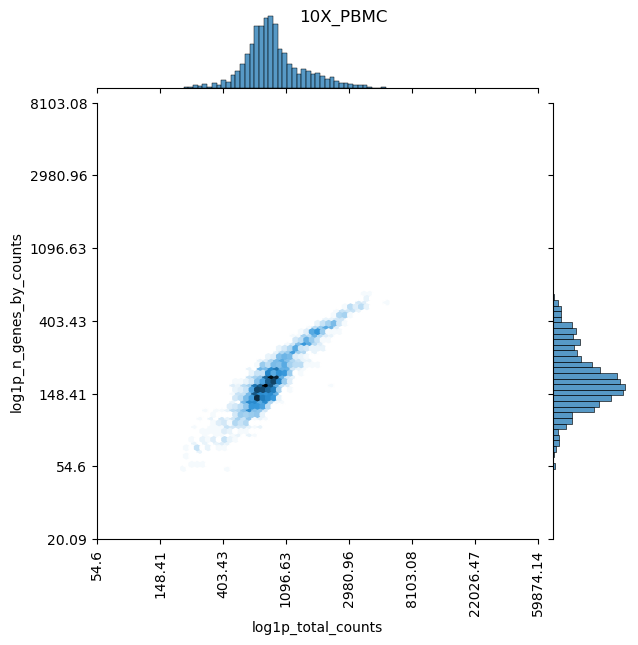

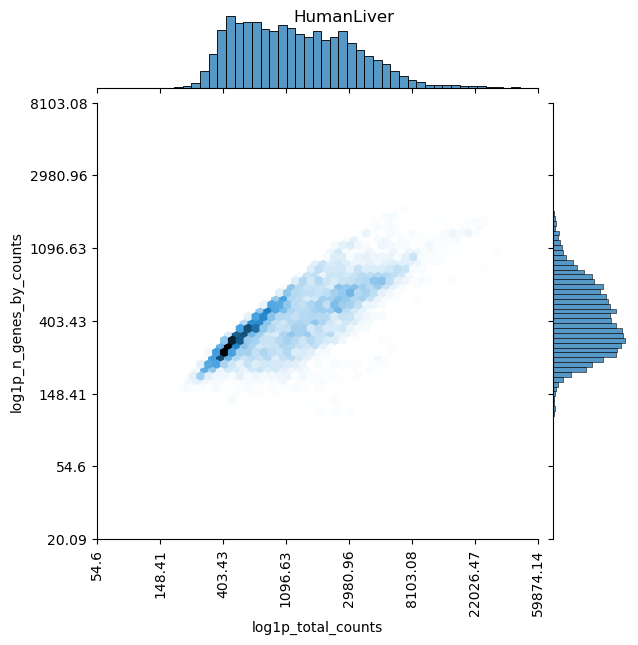

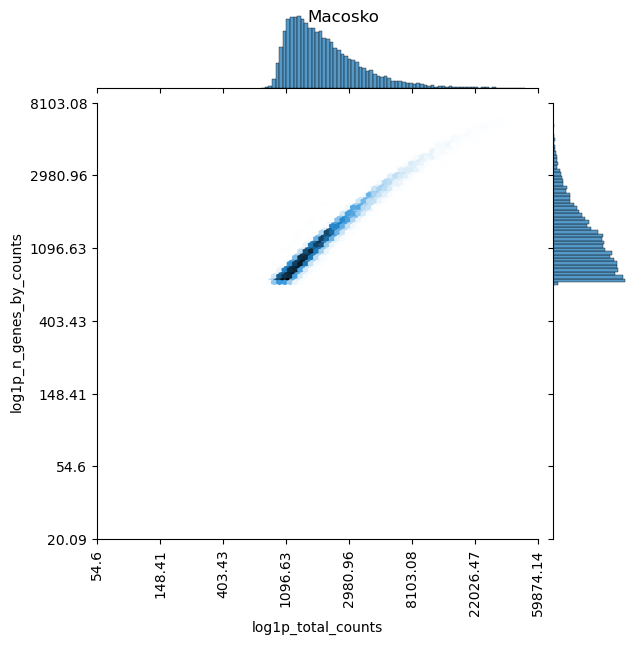

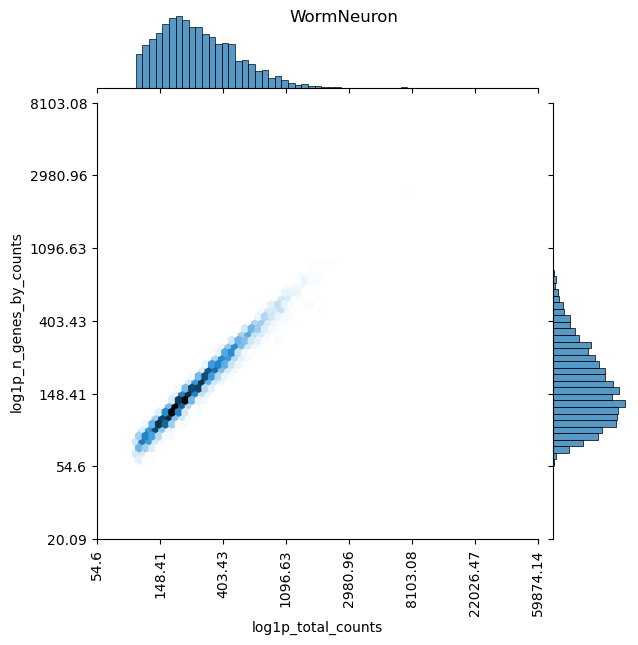

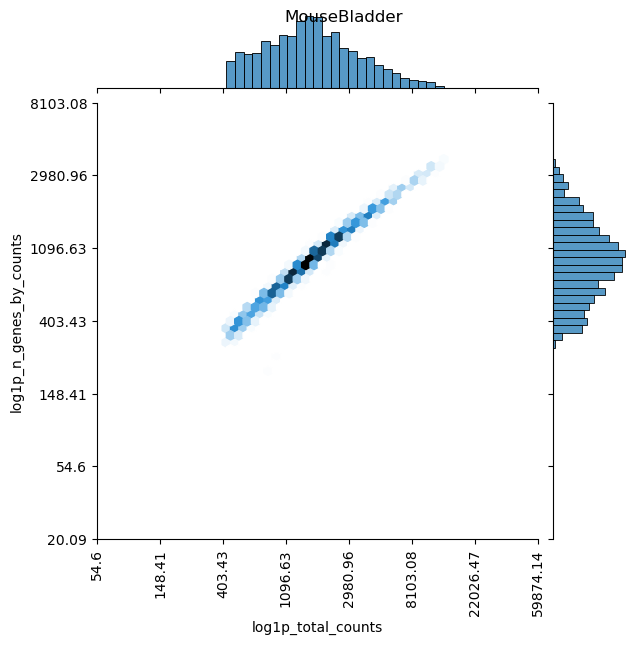

In [32]:
jointplots = []

for i, k in enumerate(adata_dict.keys()):
    adata = adata_dict[k]
    sc.pp.calculate_qc_metrics(adata, inplace=True)

    p = sns.jointplot(
        data=adata.obs,
        x="log1p_total_counts",
        y="log1p_n_genes_by_counts",
        kind="hex",
        xlim = (4,11), ylim = (3.5,9)
    )
    old_ticks = plt.xticks()
    new_labels = [round(np.exp(i),2) for i in old_ticks[0]]
    plt.xticks(old_ticks[0], new_labels, rotation = 90)

    old_ticks = plt.yticks()
    new_labels = [round(np.exp(i),2) for i in old_ticks[0]]
    plt.yticks(old_ticks[0], new_labels)
    
    p.fig.suptitle(k)

    name = f'{k}.png'
    jointplots.append(name)
    plt.show()
    p.savefig(name)

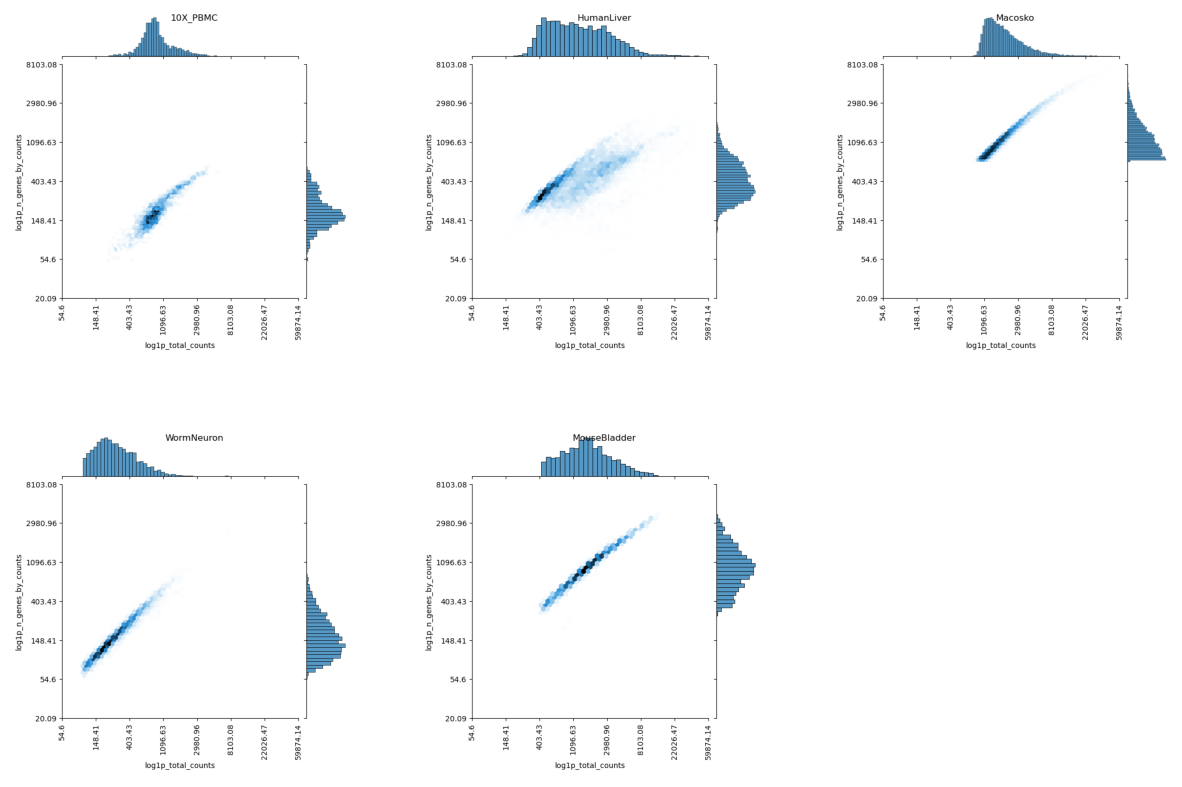

In [33]:
f, axarr = plt.subplots(2, 3,figsize = (15,10))
axarr = np.reshape(axarr, (6))
for i, j in enumerate(jointplots):
    axarr[i].imshow(mpimg.imread(j))
    #os.remove(j)
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].spines[['right', 'top', 'left', 'bottom']].set_visible(False)

axarr[i+1].set_xticks([])
axarr[i+1].set_yticks([])
axarr[i+1].spines[['right', 'top', 'left', 'bottom']].set_visible(False)

plt.show()

# Normalizamos y consideramos únicamente el 10% de las células
Únicamente se considera el 10% de las células con más conteos. 

In [34]:
for i, k in enumerate(adata_dict.keys()):
    adata = adata_dict[k]

    # adata_dict[k].X = np.array(list(map(log_1, adata.X)))
    adata = normalize(adata)

    quantile = pd.qcut(adata.obs['total_counts'], 10, labels = False) 
    adata_dict[k] = adata[quantile == 9]

    print(f'Tamaño final dataset {k}: {adata_dict[k].shape}')

Tamaño final dataset 10X_PBMC: (210, 2000)
Tamaño final dataset HumanLiver: (845, 5000)
Tamaño final dataset Macosko: (1465, 11422)
Tamaño final dataset WormNeuron: (417, 13488)
Tamaño final dataset MouseBladder: (275, 19771)


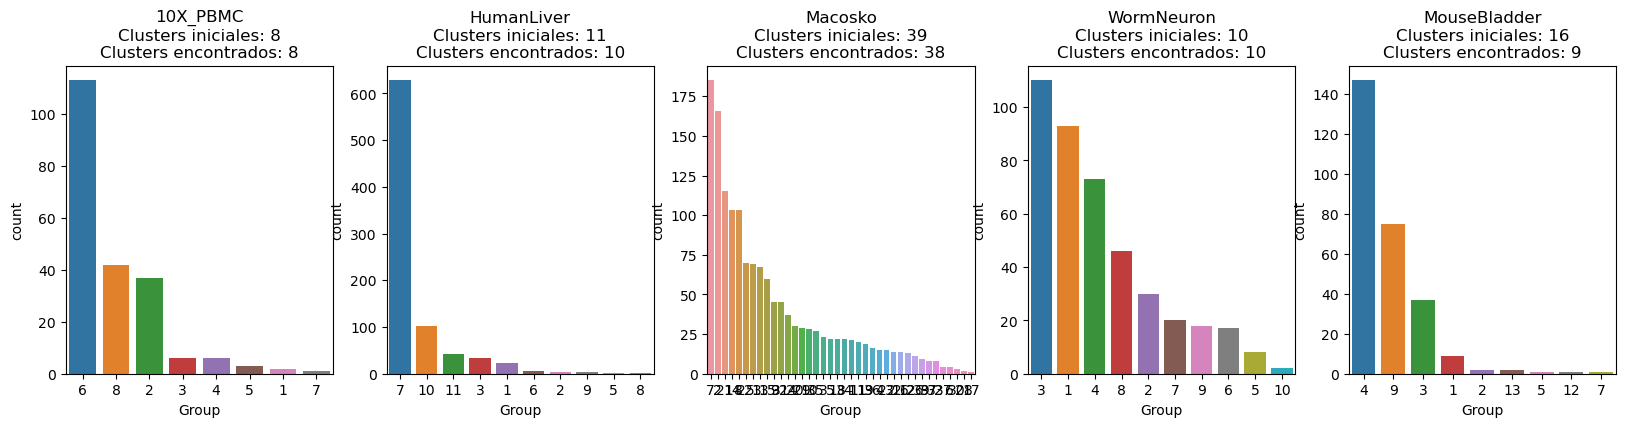

In [35]:
# Distribución de clusters en células mejor representadas
fig, axes = plt.subplots(ncols = len(adata_dict), figsize = (20,4))
for ax, (k, df) in zip(axes,adata_dict.items()):
    y = df.obs.Group
    y = y.astype(int)

    y_inicial =  np.array(data[k]['Y'])
    sns.countplot(x = y, ax = ax, order=y.value_counts().index).set(title = k + f'\nClusters iniciales: {len(set(y_inicial))}\nClusters encontrados: {len(y.unique())}')

# Similitud entre células

In [36]:
# Para el análisis, pasamos la matriz a una sparse 
matrices = {k: sp.csr_matrix(adata.X) for k, adata in adata_dict.items()}

In [37]:
# distancias_similitud_dict = {}
# for key, mat in matrices.items():
#      distancias_similitud_dict[key] = get_distances_matrix(mat, tipo = 'similitud')

100%|██████████| 275/275 [03:19<00:00,  1.38it/s]


In [38]:
# with open('resultados_distancias/distancias_similitud_normalized.pkl', 'wb') as f: 
#     pickle.dump(distancias_similitud_dict, f)

In [39]:
with open('resultados_distancias/distancias_similitud_normalized.pkl', 'rb') as f: 
    distancias_similitud_dict = pickle.load(f)     

In [42]:
distancias_similitud_dict['10X_PBMC']

array([[2000., 2000., 2000., ..., 2000., 2000., 2000.],
       [2000., 2000., 2000., ..., 2000., 2000., 2000.],
       [2000., 2000., 2000., ..., 2000., 2000., 2000.],
       ...,
       [2000., 2000., 2000., ..., 2000., 2000., 2000.],
       [2000., 2000., 2000., ..., 2000., 2000., 2000.],
       [2000., 2000., 2000., ..., 2000., 2000., 2000.]])

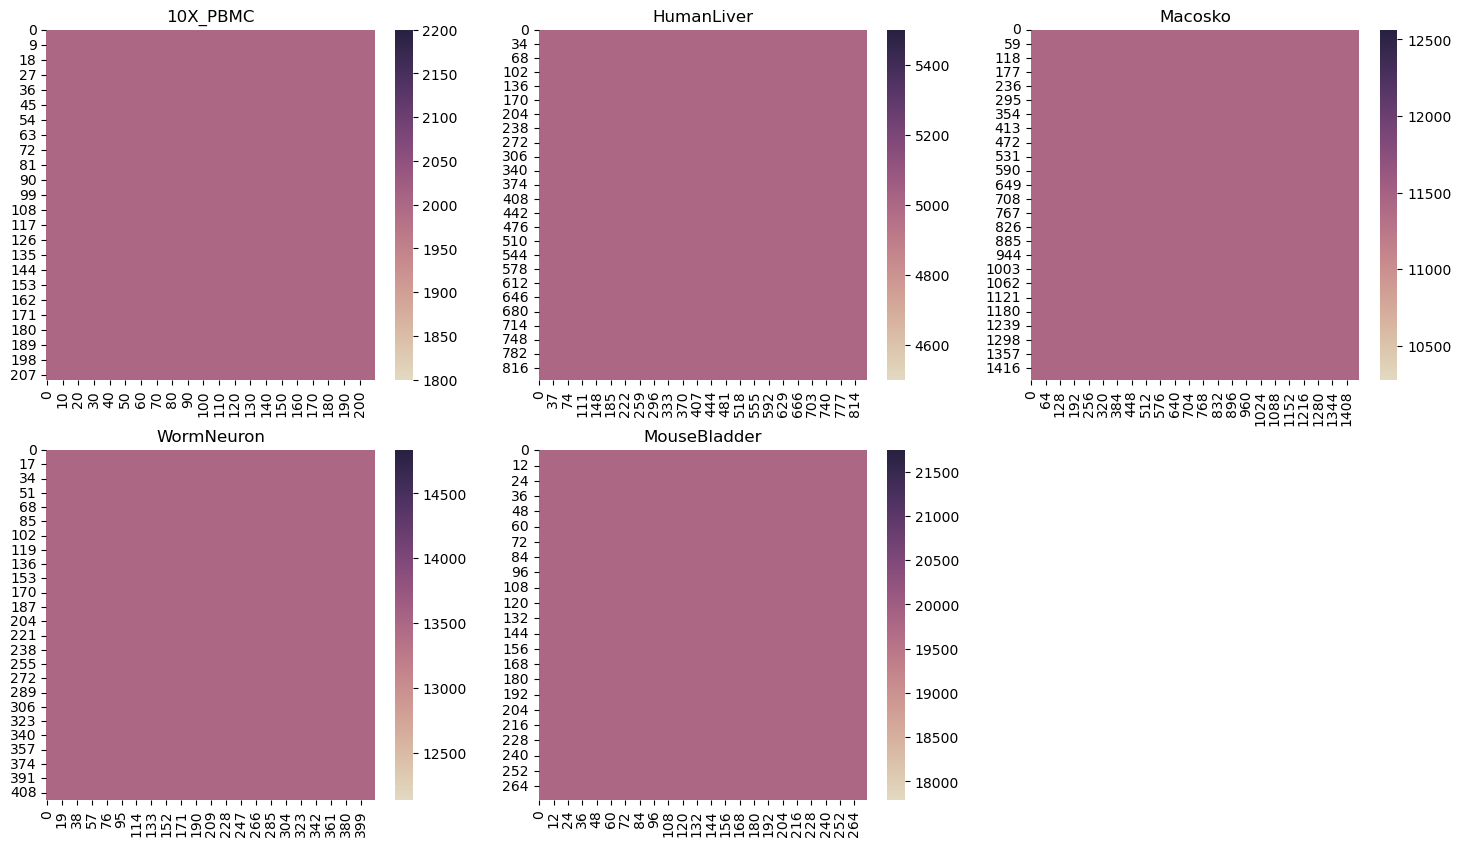

In [41]:
fig, axes_ = plt.subplots(ncols = 3, nrows = 2, figsize = (18,10))
axes = np.reshape(axes_, (6))[:-1]
p = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)

for ax, (key, distancias) in zip(axes,distancias_similitud_dict.items()):
    sns.heatmap(distancias, cmap=p, ax = ax).set(title = key)

axes_[-1][-1].set_xticks([])
axes_[-1][-1].set_yticks([])
axes_[-1][-1].spines[['right', 'top', 'left', 'bottom']].set_visible(False)

plt.show()

In [ ]:
distancias_mismo_cluster_dict, distancias_diferente_cluster_dict = distancias_mismo_diferente_cluster(distancias_similitud_dict, adata_dict)

grid = plt.GridSpec(5, 2)
fig, axes = plt.subplots(ncols = 1, nrows = 5, figsize = (10,20),sharey='row', sharex = True)

for i, (key, ax) in enumerate(zip(distancias_mismo_cluster_dict.keys(), axes)):
    distancia_mismo_cluster = distancias_mismo_cluster_dict[key]
    distancia_diferente_cluster = distancias_diferente_cluster_dict[key]

    create_subtitle(fig, grid[i, ::], key)

    sns.histplot(np.log(1+np.array(distancia_mismo_cluster)), bins = 50, ax = ax, color = 'red', alpha = 0.5, label = 'Mismo cluster').set(
        title = 'Simulitud - células mismo y distinto cluster')
    sns.histplot(np.log(1+np.array(distancia_diferente_cluster)), bins = 50, ax = ax, color = 'blue', alpha = 0.5, label = 'Diferente cluster')
    ax.legend()

# Distancia entre células

In [45]:
# distancias_euclidea_dict = {}
# for key, mat in matrices.items():
#      distancias_euclidea_dict[key] = get_distances_matrix(mat, tipo = 'euclidea')

100%|██████████| 275/275 [00:13<00:00, 20.32it/s] 


In [46]:
# with open('resultados_distancias/distancias_euclidea_normalized.pkl', 'wb') as f: 
#     pickle.dump(distancias_euclidea_dict, f)

In [30]:
with open('resultados_distancias/distancias_euclidea_normalized.pkl', 'rb') as f: 
    distancias_euclidea_dict = pickle.load(f)   

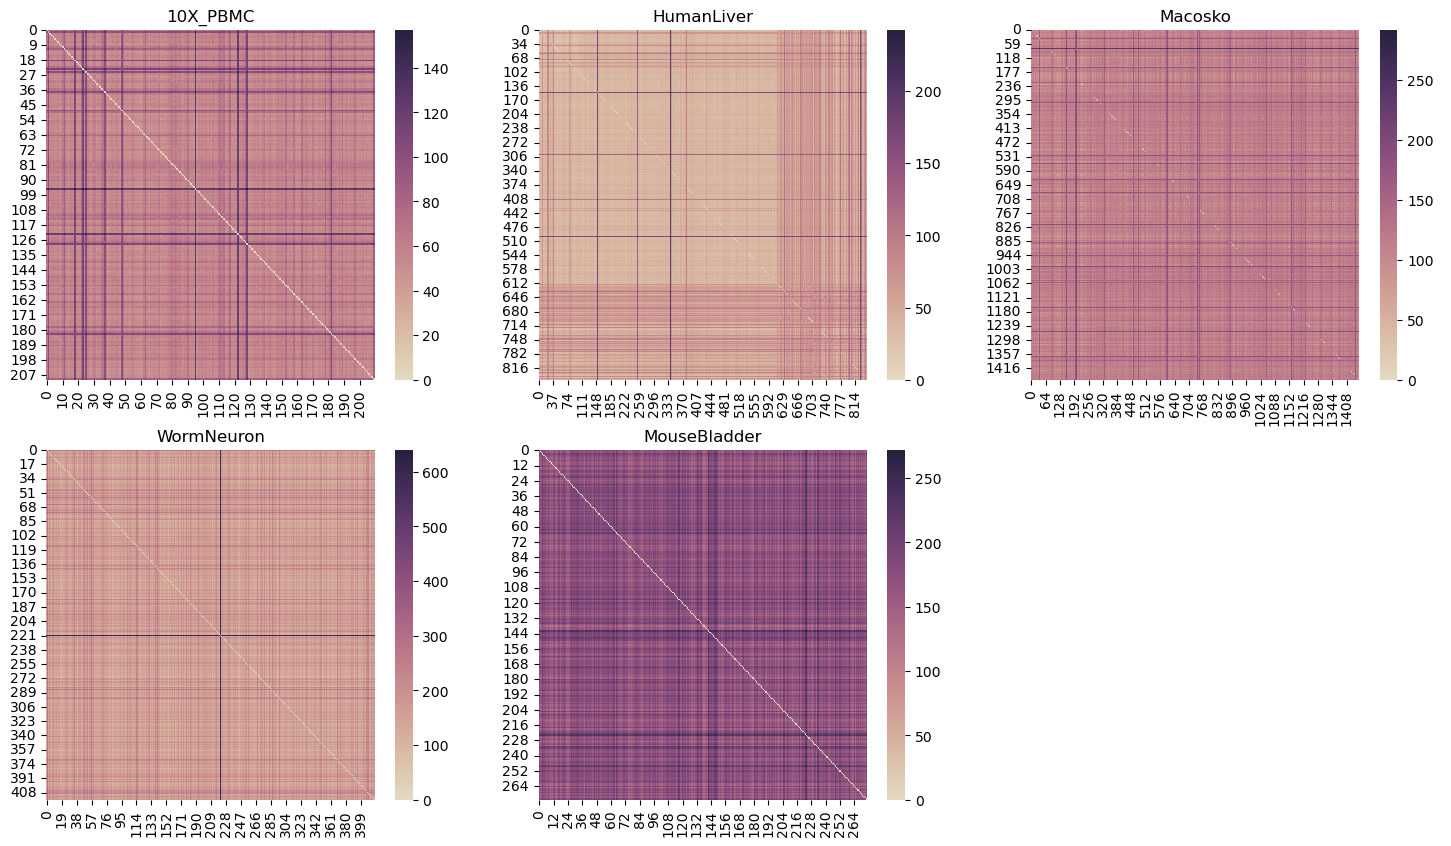

In [47]:
fig, axes_ = plt.subplots(ncols = 3, nrows = 2, figsize = (18,10))
axes = np.reshape(axes_, (6))[:-1]
p = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)

for ax, (key, distancias) in zip(axes,distancias_euclidea_dict.items()):
    sns.heatmap(distancias, cmap=p, ax = ax).set(title = key)

axes_[-1][-1].set_xticks([])
axes_[-1][-1].set_yticks([])
axes_[-1][-1].spines[['right', 'top', 'left', 'bottom']].set_visible(False)

plt.show()

  0%|          | 0/210 [00:00<?, ?it/s]

100%|██████████| 275/275 [00:02<00:00, 93.54it/s] 


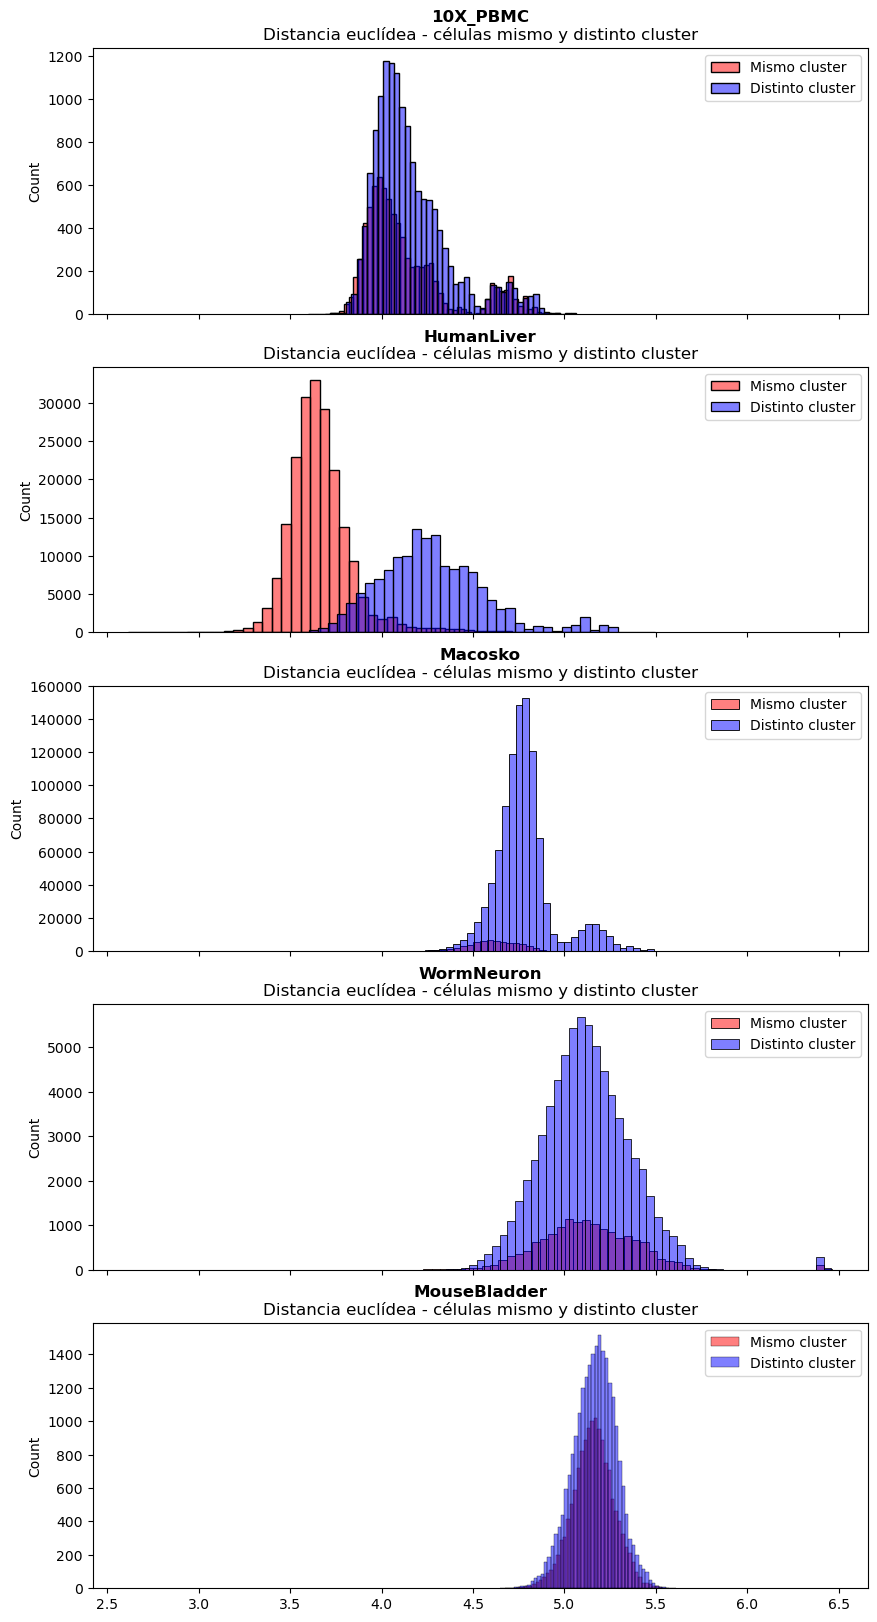

In [48]:
distancias_mismo_cluster_dict, distancias_diferente_cluster_dict = distancias_mismo_diferente_cluster(distancias_euclidea_dict, adata_dict)

grid = plt.GridSpec(5, 2)
fig, axes = plt.subplots(ncols = 1, nrows = 5, figsize = (10,20),sharey='row', sharex = True)

for i, (key, ax) in enumerate(zip(distancias_mismo_cluster_dict.keys(), axes)):
    distancia_mismo_cluster = distancias_mismo_cluster_dict[key]
    distancia_diferente_cluster = distancias_diferente_cluster_dict[key]

    create_subtitle(fig, grid[i, ::], key)

    sns.histplot(np.log(1+np.array(distancia_mismo_cluster)), bins = 50, ax = ax, alpha = 0.5, label = 'Mismo cluster', color = 'red').set(
        title = 'Distancia euclídea - células mismo y distinto cluster')
    sns.histplot(np.log(1+np.array(distancia_diferente_cluster)), bins = 50, ax = ax, alpha = 0.5, label = 'Distinto cluster', color = 'blue')
    ax.legend()

# Correlación (pearson) entre células

In [25]:
# correlacion_pearson_dict = {}
# for key, mat in matrices.items():
#     correlacion_pearson_dict[key] = get_distances_matrix(mat, tipo = 'correlacion_pearson')

In [26]:
# with open('resultados_distancias/correlacion_pearson.pkl', 'wb') as f: 
#     pickle.dump(correlacion_pearson_dict, f)     

In [31]:
with open('resultados_distancias/correlacion_pearson.pkl', 'rb') as f: 
    correlacion_pearson_dict = pickle.load(f)   

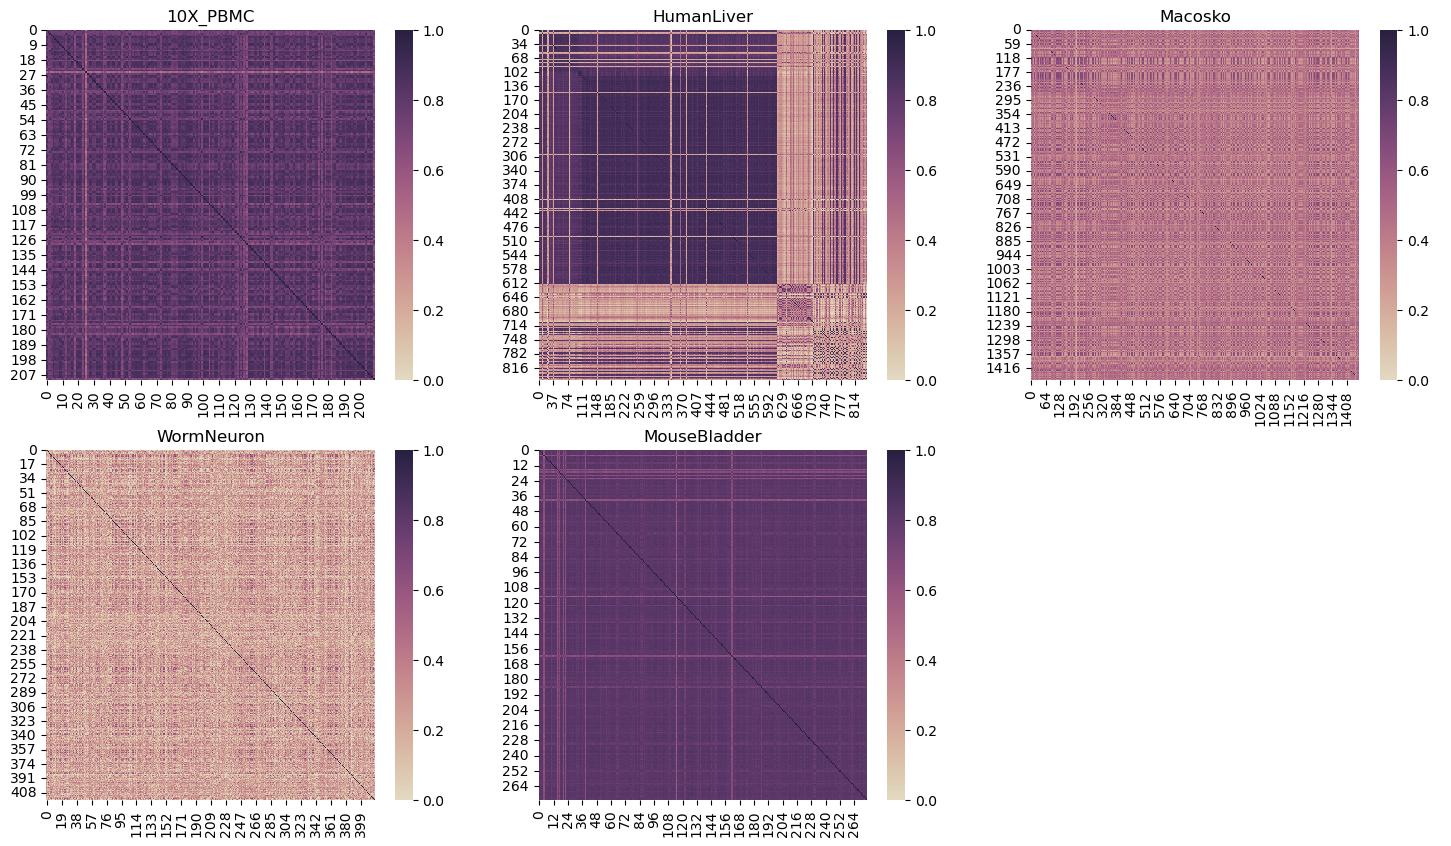

In [28]:
fig, axes_ = plt.subplots(ncols = 3, nrows = 2, figsize = (18,10))
axes = np.reshape(axes_, (6))[:-1]
p = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)

for ax, (key, distancias) in zip(axes,correlacion_pearson_dict.items()):
    sns.heatmap(distancias, cmap=p, ax = ax, vmin = 0, vmax = 1).set(title = key)

axes_[-1][-1].set_xticks([])
axes_[-1][-1].set_yticks([])
axes_[-1][-1].spines[['right', 'top', 'left', 'bottom']].set_visible(False)

plt.show()

100%|██████████| 275/275 [00:06<00:00, 42.18it/s] 


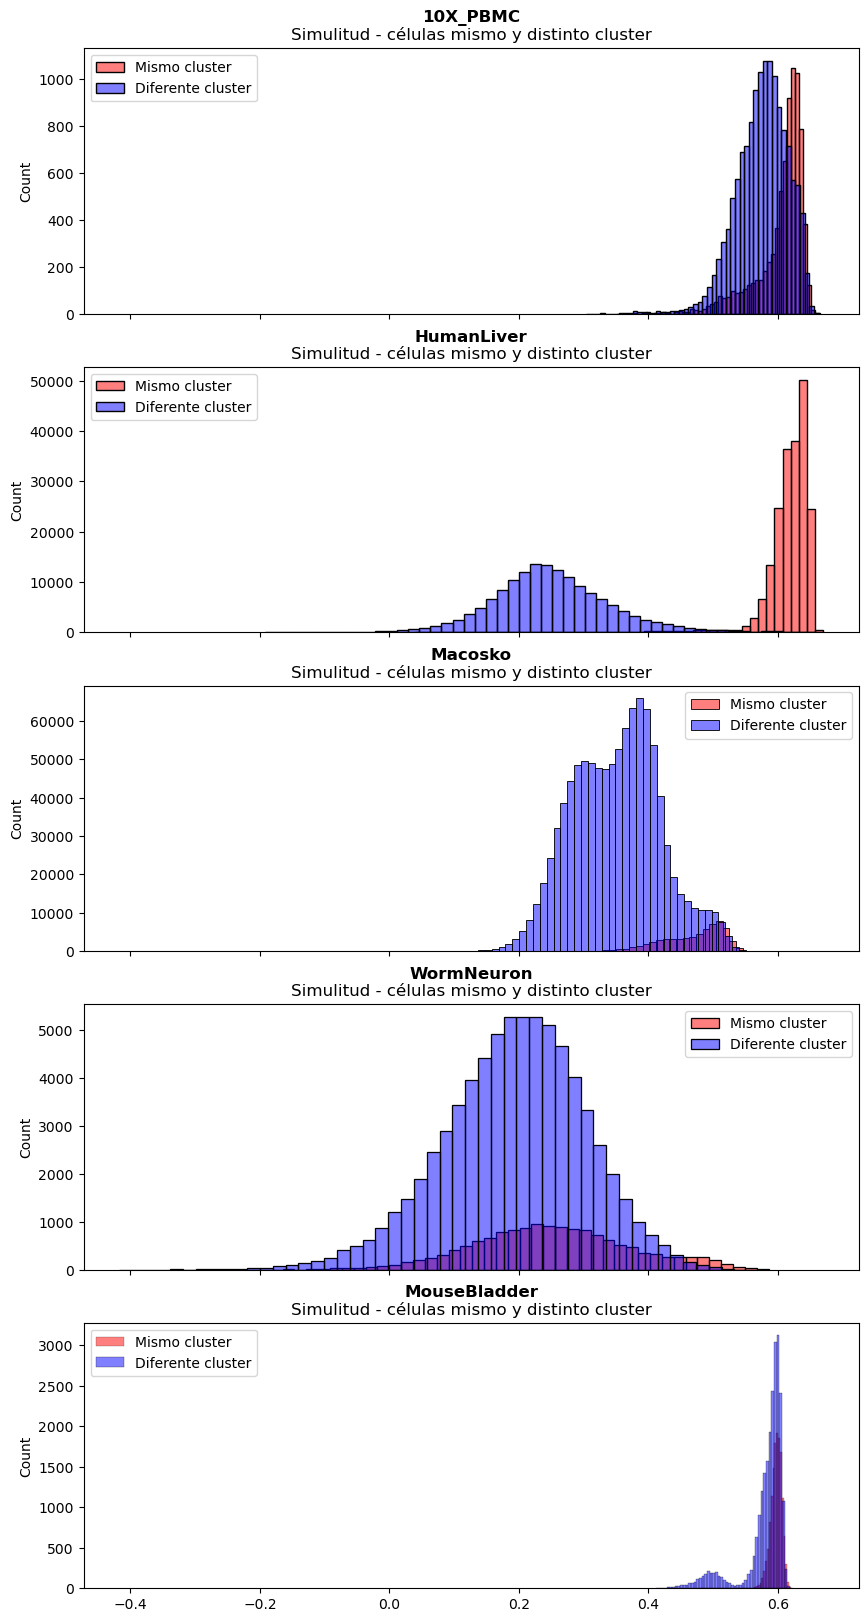

In [29]:
distancias_mismo_cluster_dict, distancias_diferente_cluster_dict = distancias_mismo_diferente_cluster(correlacion_pearson_dict, adata_dict)

grid = plt.GridSpec(5, 2)
fig, axes = plt.subplots(ncols = 1, nrows = 5, figsize = (10,20),sharey='row', sharex = True)

for i, (key, ax) in enumerate(zip(distancias_mismo_cluster_dict.keys(), axes)):
    distancia_mismo_cluster = distancias_mismo_cluster_dict[key]
    distancia_diferente_cluster = distancias_diferente_cluster_dict[key]

    create_subtitle(fig, grid[i, ::], key)

    sns.histplot(np.log(1+np.array(distancia_mismo_cluster)), bins = 50, ax = ax, color = 'red', alpha = 0.5, label = 'Mismo cluster').set(
        title = 'Simulitud - células mismo y distinto cluster')
    sns.histplot(np.log(1+np.array(distancia_diferente_cluster)), bins = 50, ax = ax, color = 'blue', alpha = 0.5, label = 'Diferente cluster')
    ax.legend()

# Rango de Spearman

In [30]:
# rango_spearman_dict = {}
# for key, mat in matrices.items(): 
#     rango_spearman_dict[key] = get_distances_matrix(mat, tipo = 'rango_spearman')

In [31]:
# with open('resultados_distancias/rango_spearman.pkl', 'wb') as f: 
#     pickle.dump(rango_spearman_dict, f)     

In [32]:
with open('resultados_distancias/rango_spearman.pkl', 'rb') as f: 
    rango_spearman_dict = pickle.load(f)   

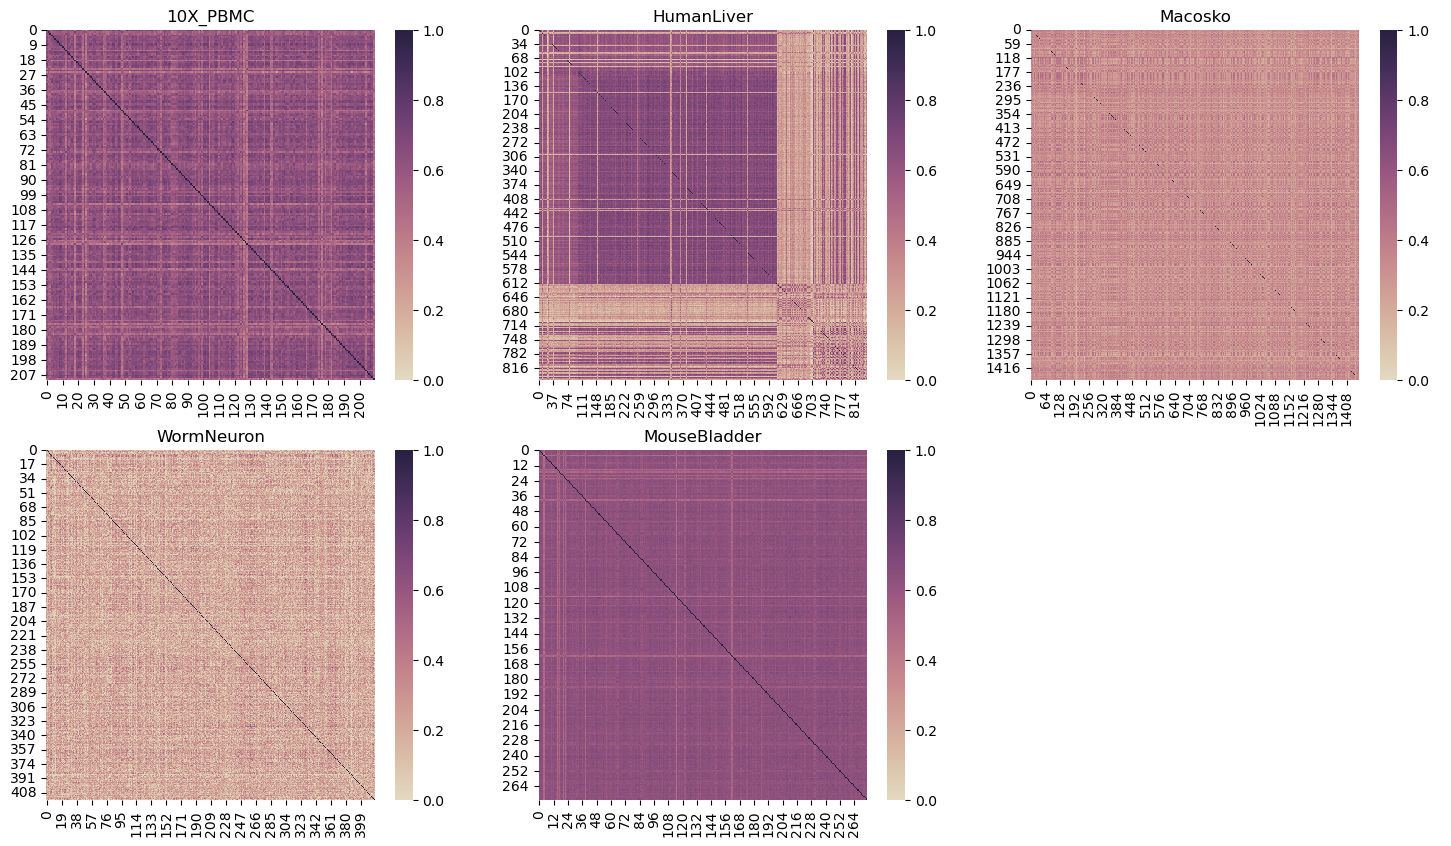

In [33]:
fig, axes_ = plt.subplots(ncols = 3, nrows = 2, figsize = (18,10))
axes = np.reshape(axes_, (6))[:-1]
p = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)

for ax, (key, distancias) in zip(axes,rango_spearman_dict.items()):
    sns.heatmap(distancias, cmap=p, ax = ax, vmin = 0, vmax = 1).set(title = key)

axes_[-1][-1].set_xticks([])
axes_[-1][-1].set_yticks([])
axes_[-1][-1].spines[['right', 'top', 'left', 'bottom']].set_visible(False)

plt.show()

100%|██████████| 275/275 [00:06<00:00, 43.19it/s] 


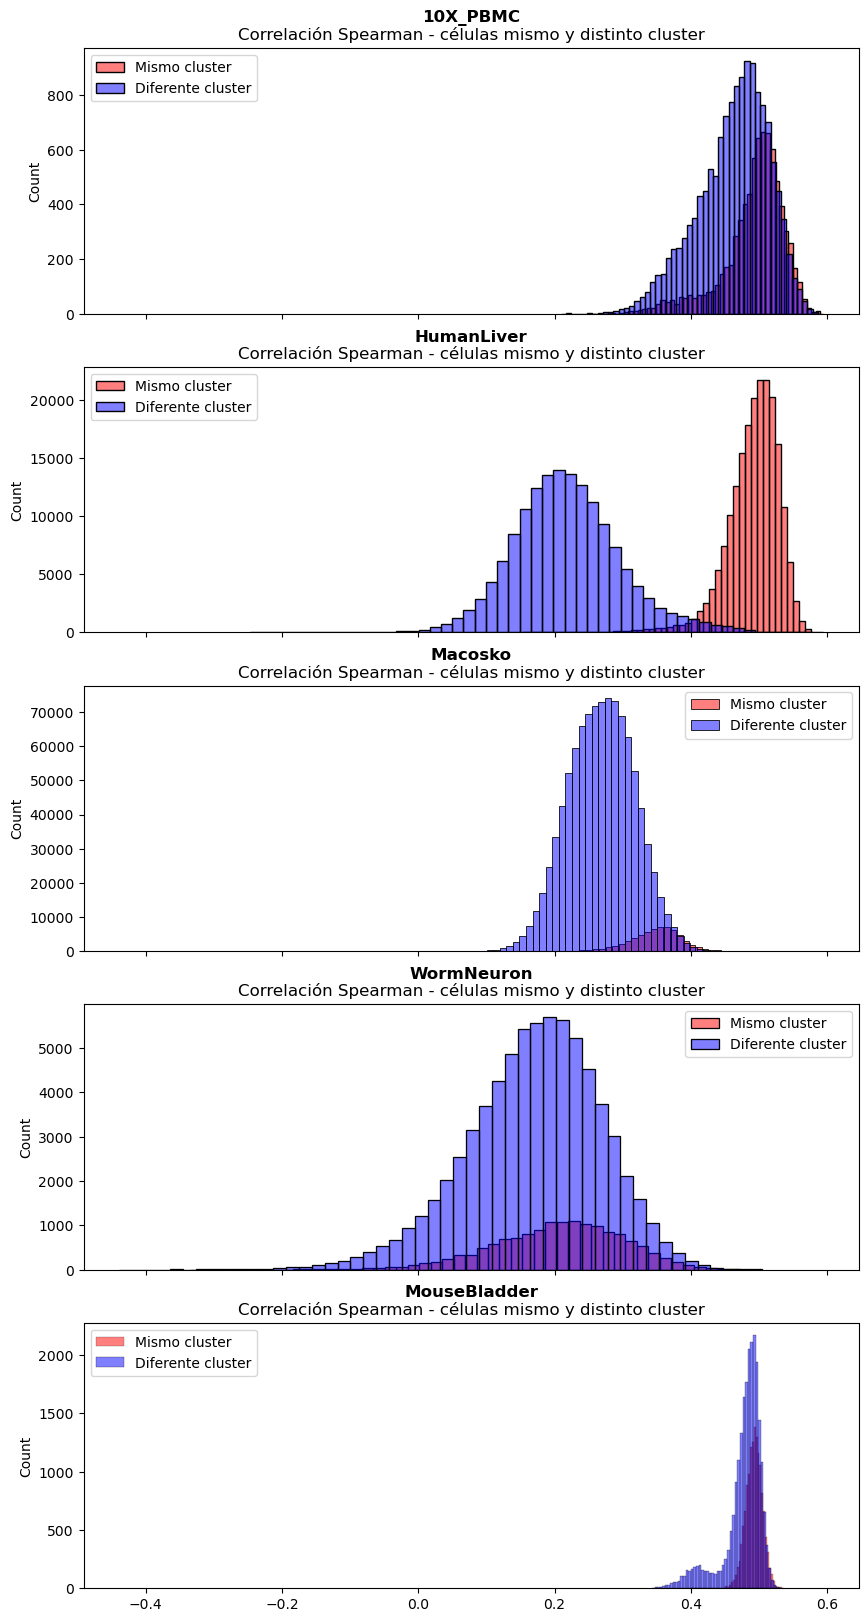

In [34]:
distancias_mismo_cluster_dict, distancias_diferente_cluster_dict = distancias_mismo_diferente_cluster(rango_spearman_dict, adata_dict)

grid = plt.GridSpec(5, 2)
fig, axes = plt.subplots(ncols = 1, nrows = 5, figsize = (10,20),sharey='row', sharex = True)

for i, (key, ax) in enumerate(zip(distancias_mismo_cluster_dict.keys(), axes)):
    distancia_mismo_cluster = distancias_mismo_cluster_dict[key]
    distancia_diferente_cluster = distancias_diferente_cluster_dict[key]

    create_subtitle(fig, grid[i, ::], key)

    sns.histplot(np.log(1+np.array(distancia_mismo_cluster)), bins = 50, ax = ax, color = 'red', alpha = 0.5, label = 'Mismo cluster').set(
        title = 'Correlación Spearman - células mismo y distinto cluster')
    sns.histplot(np.log(1+np.array(distancia_diferente_cluster)), bins = 50, ax = ax, color = 'blue', alpha = 0.5, label = 'Diferente cluster')
    ax.legend()

# Clustering de células seleccionadas

In [35]:
for k in adata_dict.keys(): 
    y = adata_dict[k].obs.Group
    x = adata_dict[k].X 

    pca = PCA(n_components = 32)
    z = pca.fit_transform(x)

    n = len(set(y))
    kmeans = KMeans(n_clusters=n, random_state=123)
    y_pred = kmeans.fit_predict(z)

    acc = cluster_acc(y, y_pred)
    nmi = normalized_mutual_info_score(y, y_pred)
    ari = adjusted_rand_score(y, y_pred)

    print(f'Dataset {k}. ACC: {round(acc,3)}. NMI: {round(nmi,3)}. ARI: {round(ari,3)}')

Dataset 10X_PBMC. ACC: 0.543. NMI: 0.562. ARI: 0.271
Dataset HumanLiver. ACC: 0.599. NMI: 0.655. ARI: 0.364
Dataset Macosko. ACC: 0.453. NMI: 0.641. ARI: 0.433
Dataset WormNeuron. ACC: 0.698. NMI: 0.718. ARI: 0.549
Dataset MouseBladder. ACC: 0.455. NMI: 0.55. ARI: 0.323


In [36]:
# Para calcular las correlaciones tener en cuenta solo los genes que tienen expresion en ambas celulas
# Gráficos uno encima del otro
# Intentar con Grafos el Human Liver 
# KMeans con correlacion intentar
# Averiguar cómo se sacaron los labels reales

# UMAP y TSNE + clustering

# KMeans con correlación

In [33]:
def assign_cluster(point, centroids, dist_matrix):
    """
    Función que asigna el cluster más cercano al punto.
    La concepción de cercanía la da la función de distancias dist_function. Se minimiza esta.
    """
    if point in centroids: 
        return np.where(centroids == point)[0][0]
    else:
        distances = np.array([dist_matrix[x, point] for x in centroids]) 
        rta = np.argmin(distances)
        return rta

In [34]:
def find_new_centroids(X, labels, num_clusters, dist_matrix):
    """
    A partir de los labels que se asignaron a los datos, encuentra nuevos centroides.
    Si un cluster está vacío, encuentra un nuevo centroide al azar.
    Si el cluster no está vacío, asigna como centoride la media de los valores (componente por componente) de los datos en él.
    """
    new_centroids = []
    for i in range(num_clusters):
        points_cluster = [index for index in range(len(X)) if labels[index] == i] # Seleccionamos los indices de los puntos en el cluster
        corr_cluster = np.zeros((len(points_cluster), len(points_cluster))) 

        # Iteramos sobre los puntos del cluster y obtenemos la distancia con todos los otros puntos del cluster
        for p1 in range(len(points_cluster)):
            index_point1 = points_cluster[p1]
            for p2 in range(p1,len(points_cluster)):
                index_point2 = points_cluster[p2]

                corr = dist_matrix[index_point1, index_point2]
                corr_cluster[p1,p2] = corr
                corr_cluster[p2,p1] = corr
        
        index_max_correlation = np.argmax( np.mean(corr_cluster, axis = 1) )
        new_centroid = points_cluster[index_max_correlation]
        
        new_centroids.append(new_centroid)
    
    return np.array(new_centroids)

In [35]:
def dist_cluster_centers(centroids, new_centroids, dist_matrix):
    """
    Calcula la distancia promedio entre los centroides anteriores y los nuevos. 
    Esto, a partir de una función de distancia ingresada como parámetro
    """
    r = [dist_matrix[new_centroids[c], centroids[c]] for c in range(len(centroids))]
    return np.mean(r)

In [36]:
def kmeans_from_distance_matrix(X, dist_matrix, num_clusters, max_iterations=100):
    """
    Ejecuta KMeans a partir de:
    - X: matriz NxM donde N es el número de puntos a considerar y M la dimensionalidad de estos.
    - dist_matrix: matriz NxN de distancias entre puntos
    - dist_function: función que calcula la distancia a usar
    - num_clusters: número de clusters a encontrar
    """
    X_dense = np.array(X.todense())
    num_points = len(dist_matrix)
    
    # Inicialización aleatoria de los centroides
    np.random.seed(0)
    centroids = np.random.choice(num_points, size=num_clusters, replace=False) # Los centroides se guardan como índices 
    
    for i in range(max_iterations):        
        # Asignar puntos a los clusters basados en la distancia a los centroides
        labels = np.array([assign_cluster(point, centroids, dist_matrix) for point in range(num_points)])
        
        # Actualizar los centroides como el promedio de los puntos en cada cluster
        new_centroids = find_new_centroids(X_dense, labels, num_clusters, dist_matrix)

        print(f'Iteración {i}. Distancia promedio entre centroides antes y después: {dist_cluster_centers(centroids, new_centroids, dist_matrix)}')

        # Detener si los centroides no cambiaron significativamente
        if np.allclose(new_centroids, centroids):
            break
        
        centroids = new_centroids
        
    return labels

In [37]:
name = '10X_PBMC'
X = matrices[name]
dist_matrix = rango_spearman_dict[name]
#dist_function = lambda x,y: spearmanr(x,y).correlation
num_clusters = 8

labels = kmeans_from_distance_matrix(X, dist_matrix, num_clusters)

Iteración 0. Distancia promedio entre centroides antes y después: 0.6438923369641254
Iteración 1. Distancia promedio entre centroides antes y después: 0.667214758116152
Iteración 2. Distancia promedio entre centroides antes y después: 0.671175134986089
Iteración 3. Distancia promedio entre centroides antes y después: 0.6398041234149663
Iteración 4. Distancia promedio entre centroides antes y después: 0.7370991104067652
Iteración 5. Distancia promedio entre centroides antes y después: 0.7151448011841208
Iteración 6. Distancia promedio entre centroides antes y después: 0.5986665963579139
Iteración 7. Distancia promedio entre centroides antes y después: 0.5877676955243898
Iteración 8. Distancia promedio entre centroides antes y después: 0.49480126506230304
Iteración 9. Distancia promedio entre centroides antes y después: 0.6713547088946032
Iteración 10. Distancia promedio entre centroides antes y después: 0.7145247476534197
Iteración 11. Distancia promedio entre centroides antes y después

In [38]:
name = '10X_PBMC'
X = matrices[name]
dist_matrix = distancias_euclidea_dict[name]
#dist_function = euclidean
num_clusters = 8

kmeans_from_distance_matrix(X, dist_matrix, num_clusters)

Iteración 0. Distancia promedio entre centroides antes y después: 8.264281034469604
Iteración 1. Distancia promedio entre centroides antes y después: 1.2667344808578491
Iteración 2. Distancia promedio entre centroides antes y después: 1.40964937210083
Iteración 3. Distancia promedio entre centroides antes y después: 1.145212173461914
Iteración 4. Distancia promedio entre centroides antes y después: 1.2667344808578491
Iteración 5. Distancia promedio entre centroides antes y después: 1.40964937210083
Iteración 6. Distancia promedio entre centroides antes y después: 1.145212173461914
Iteración 7. Distancia promedio entre centroides antes y después: 1.2667344808578491
Iteración 8. Distancia promedio entre centroides antes y después: 1.40964937210083
Iteración 9. Distancia promedio entre centroides antes y después: 1.145212173461914
Iteración 10. Distancia promedio entre centroides antes y después: 1.2667344808578491
Iteración 11. Distancia promedio entre centroides antes y después: 1.40964

array([5, 7, 0, 5, 5, 3, 5, 5, 5, 3, 4, 5, 0, 3, 5, 4, 2, 5, 7, 5, 5, 3,
       4, 7, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 0, 6, 5, 5, 5, 5, 5, 5,
       3, 4, 5, 5, 7, 4, 4, 5, 4, 0, 4, 2, 4, 5, 3, 5, 3, 3, 4, 5, 4, 5,
       2, 5, 4, 5, 3, 3, 3, 0, 3, 5, 5, 3, 5, 2, 1, 3, 5, 5, 5, 3, 3, 5,
       4, 5, 2, 3, 5, 5, 5, 2, 4, 5, 5, 0, 5, 5, 5, 5, 0, 3, 4, 5, 5, 5,
       5, 3, 4, 5, 5, 5, 4, 1, 5, 2, 5, 4, 7, 5, 0, 3, 0, 6, 7, 5, 5, 2,
       5, 5, 1, 5, 3, 4, 5, 0, 5, 5, 5, 0, 0, 5, 5, 5, 4, 5, 4, 3, 5, 5,
       5, 4, 5, 2, 5, 4, 5, 2, 3, 5, 3, 5, 0, 2, 5, 5, 4, 4, 3, 3, 0, 3,
       0, 3, 0, 4, 4, 4, 7, 5, 5, 2, 3, 4, 4, 5, 4, 3, 5, 5, 5, 5, 4, 3,
       5, 5, 3, 5, 5, 5, 0, 5, 5, 5, 5, 0], dtype=int64)

In [39]:
name = '10X_PBMC'
X = matrices[name]
dist_matrix = correlacion_pearson_dict[name]
#dist_function = lambda x,y: pearsonr(x,y).statistic
num_clusters = 8

kmeans_from_distance_matrix(X, dist_matrix, num_clusters)

Iteración 0. Distancia promedio entre centroides antes y después: 0.7992864998987108
Iteración 1. Distancia promedio entre centroides antes y después: 0.8045949978885045
Iteración 2. Distancia promedio entre centroides antes y después: 0.8376544085668387
Iteración 3. Distancia promedio entre centroides antes y después: 0.8418765750470535
Iteración 4. Distancia promedio entre centroides antes y después: 0.8007798133521593
Iteración 5. Distancia promedio entre centroides antes y después: 0.8020803391704184
Iteración 6. Distancia promedio entre centroides antes y después: 0.8697564435446022
Iteración 7. Distancia promedio entre centroides antes y después: 0.8385841608922261
Iteración 8. Distancia promedio entre centroides antes y después: 0.824902878395988
Iteración 9. Distancia promedio entre centroides antes y después: 0.8372245789668799
Iteración 10. Distancia promedio entre centroides antes y después: 0.794227516085451
Iteración 11. Distancia promedio entre centroides antes y después:

array([4, 0, 0, 3, 4, 3, 4, 3, 7, 3, 3, 4, 0, 5, 4, 7, 4, 3, 0, 4, 4, 4,
       4, 0, 4, 7, 4, 4, 4, 4, 4, 0, 4, 4, 4, 3, 0, 7, 4, 4, 4, 4, 4, 4,
       4, 3, 4, 4, 7, 7, 3, 4, 7, 2, 3, 4, 4, 0, 3, 4, 4, 4, 7, 4, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3,
       7, 3, 4, 1, 4, 4, 3, 4, 3, 4, 4, 0, 4, 4, 4, 4, 7, 4, 7, 4, 3, 4,
       4, 4, 7, 4, 4, 3, 4, 4, 4, 4, 4, 7, 0, 4, 3, 4, 0, 7, 0, 3, 4, 4,
       4, 3, 3, 4, 3, 3, 4, 7, 4, 4, 4, 4, 0, 3, 4, 4, 3, 3, 7, 4, 4, 4,
       4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 0, 4, 3, 4, 7, 7, 4, 3, 7, 3,
       0, 4, 7, 3, 4, 7, 7, 3, 3, 4, 4, 3, 7, 4, 3, 3, 3, 4, 4, 4, 2, 4,
       4, 4, 4, 4, 4, 4, 0, 4, 4, 6, 3, 0], dtype=int64)

# Birch con células bien representadas

In [54]:
def assign_clusters_from_represented_points(X_represented, labels_represented, X):
    
    labels = []
    for x in X:
        distances = np.array([euclidean(x,x_r) for x_r in X_represented])
        min_distance = np.argmin(distances)
        label_min_distance  = labels_represented[min_distance]

        labels.append(label_min_distance)

    return np.array(labels)

In [59]:
# KMEANS

for key, df in adata_dict.items():
    X = df.X
    y = df.obs.Group.values

    pca = PCA(n_components = 32)
    z = pca.fit_transform(X)

    model, metrics = model_KMeans(z, y)
    acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
    print(f'\nModelo (puntos representados) {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')

    labels_represented = model.labels_
    
    X_complete = np.array(data[key]['X'])
    y = np.array(data[key]['Y'])
    labels = assign_clusters_from_represented_points(X, labels_represented, X_complete)

    acc, nmi, ari = cluster_acc(y,labels), normalized_mutual_info_score(y,labels), adjusted_rand_score(y,labels)
    print(f'\n--- Modelo (completo) {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')


Modelo (puntos representados) 10X_PBMC ---- ACC 0.5714285714285714. NMI 0.5758578523038665. ARI 0.29712459442597694.

--- Modelo (completo) 10X_PBMC ---- ACC 0.5738095238095238. NMI 0.5440975775340227. ARI 0.4078938207956335.

Modelo (puntos representados) HumanLiver ---- ACC 0.5396449704142012. NMI 0.6137027984885358. ARI 0.3141528070898163.

--- Modelo (completo) HumanLiver ---- ACC 0.7199194694457604. NMI 0.6297559583480721. ARI 0.7872601072444775.

Modelo (puntos representados) Macosko ---- ACC 0.4614334470989761. NMI 0.6606628526654059. ARI 0.4367369189942673.

--- Modelo (completo) Macosko ---- ACC 0.3462089674469392. NMI 0.4711480439296181. ARI 0.3022695525584591.

Modelo (puntos representados) WormNeuron ---- ACC 0.657074340527578. NMI 0.72155898080139. ARI 0.49485290125345927.

--- Modelo (completo) WormNeuron ---- ACC 0.4899665551839465. NMI 0.49238823484830213. ARI 0.25391253381553713.

Modelo (puntos representados) MouseBladder ---- ACC 0.49454545454545457. NMI 0.545076384

In [62]:
# BIRCH

for key, df in adata_dict.items():
    X = df.X
    y = df.obs.Group.values

    pca = PCA(n_components = 32)
    z = pca.fit_transform(X)

    model, _, _, metrics = model_BIRCH(z, y)
    acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
    print(f'\nModelo {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')

    labels_represented = model.labels_
    
    X_complete = np.array(data[key]['X'])
    y = np.array(data[key]['Y'])
    labels = assign_clusters_from_represented_points(X, labels_represented, X_complete)

    acc, nmi, ari = cluster_acc(y,labels), normalized_mutual_info_score(y,labels), adjusted_rand_score(y,labels)
    print(f'\n--- Modelo (completo) {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')


Modelo 10X_PBMC ---- ACC 0.5380952380952381. NMI 0.55494358021018. ARI 0.2731690780201128.

--- Modelo (completo) 10X_PBMC ---- ACC 0.5738095238095238. NMI 0.5439255820100407. ARI 0.4078452342944622.

Modelo HumanLiver ---- ACC 0.9502958579881656. NMI 0.9131459574885833. ARI 0.9808704703202354.

--- Modelo (completo) HumanLiver ---- ACC 0.7222880151586926. NMI 0.6039571368671973. ARI 0.7386835526426963.

Modelo Macosko ---- ACC 0.3433447098976109. NMI 0.46290039201970884. ARI 0.16171281353524194.

--- Modelo (completo) Macosko ---- ACC 0.3492800109192657. NMI 0.3445261184760689. ARI 0.21377455162082806.

Modelo WormNeuron ---- ACC 0.7985611510791367. NMI 0.7352022543972623. ARI 0.5954248464361929.

--- Modelo (completo) WormNeuron ---- ACC 0.5869565217391305. NMI 0.49736094552618876. ARI 0.3070134773376624.

Modelo MouseBladder ---- ACC 0.7454545454545455. NMI 0.5903281802378896. ARI 0.576296289703751.

--- Modelo (completo) MouseBladder ---- ACC 0.5127458120903132. NMI 0.499765044103

In [63]:
# DBSCAN

for key, df in adata_dict.items():
    X = df.X
    y = df.obs.Group.values

    pca = PCA(n_components = 32)
    z = pca.fit_transform(X)

    model, _, _, metrics = model_DBSCAN(z, y)
    acc, nmi, ari = metrics['Accuracy'], metrics['NMI'], metrics['ARI']
    print(f'\nModelo {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')

    labels_represented = model.labels_
    
    X_complete = np.array(data[key]['X'])
    y = np.array(data[key]['Y'])
    labels = assign_clusters_from_represented_points(X, labels_represented, X_complete)

    acc, nmi, ari = cluster_acc(y,labels), normalized_mutual_info_score(y,labels), adjusted_rand_score(y,labels)
    print(f'\n--- Modelo (completo) {key} ---- ACC {acc}. NMI {nmi}. ARI {ari}.')


Modelo 10X_PBMC ---- ACC 0.6190476190476191. NMI 0.29654231890024163. ARI 0.17794957578792442.

--- Modelo (completo) 10X_PBMC ---- ACC 0.3047619047619048. NMI 0.0027321979800266497. ARI 9.248685030346854e-05.

Modelo HumanLiver ---- ACC 0.9633136094674556. NMI 0.931579515841734. ARI 0.9920976489917632.

--- Modelo (completo) HumanLiver ---- ACC 0.71328754144955. NMI 0.6261567018103052. ARI 0.7750648726445276.

Modelo Macosko ---- ACC 0.336518771331058. NMI 0.4200413246039422. ARI 0.1479870043821632.

--- Modelo (completo) Macosko ---- ACC 0.3172729133965741. NMI 0.22415339242807567. ARI 0.05646231136624862.

Modelo WormNeuron ---- ACC 0.46522781774580335. NMI 0.35485622441782105. ARI 0.1537137290719948.

--- Modelo (completo) WormNeuron ---- ACC 0.32178690874343047. NMI 0.19044220251648136. ARI 0.06704236878343253.

Modelo MouseBladder ---- ACC 0.7636363636363637. NMI 0.4854509774605132. ARI 0.5074802202972635.

--- Modelo (completo) MouseBladder ---- ACC 0.31500364166059724. NMI 0.1

# Pendientes

In [ ]:
# Buscar un simulador de Single Cell
# Leer expresion diferencial DSeq

# Papers de biología de desarrollo

# Correr BIRCH con solo las celulas bien representadas